In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Functions**:

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from skimage.io import imread
from skimage.transform import resize
import glob
import numpy as np
import torch.nn.functional as F

import matplotlib.pyplot as plt

def post_process(model_output):
    # Apply softmax to convert model output to probabilities
    probabilities = torch.nn.functional.softmax(model_output, dim=1)

    # Take the class with the highest probability (argmax)
    predicted_class = torch.argmax(probabilities, dim=1).float()

    return predicted_class

def preprocess_image(img_path, target_shape=(128, 128)):
    img = imread(img_path, as_gray=True)
    img = img.astype(np.float32) / np.max(img[:])  # Normalize pixel values to [0, 1]

    # Resize using PyTorch
    img = F.interpolate(torch.unsqueeze(torch.unsqueeze(torch.as_tensor(img), 0), 0), size=target_shape, mode='nearest')

    # Remove the extra dimensions added by interpolate
    img = img.squeeze(0).squeeze(0)

    return img.unsqueeze(0)  # Add batch and channel dimensions


def load_and_resize_label(lbl_path, target_shape=(128, 128), num_classes=3):
    lbl = imread(lbl_path, as_gray=True)
    lbl = lbl.astype(np.float32) / np.max(lbl[:])  # Normalize pixel values to [0, 1]
    lbl = np.expand_dims(lbl, axis=-1)  # Add channel dimension
    # Convert to PyTorch tensor with torch.as_tensor
    lbl = torch.as_tensor(lbl).permute(2, 0, 1)
    # Resize using PyTorch
    lbl = F.interpolate(lbl.unsqueeze(0), size=target_shape, mode='nearest')
    # Remove the extra dimension added by interpolate
    lbl = lbl.squeeze(0)

    return lbl


from torch.utils.data import Dataset

from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

import numpy as np
class CustomDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def classify_label(self, label):
        mapping = {0.0: 0, 0.501960813999176: 1, 1.0: 2}

    # Convert to numpy array and ensure the array is of type float
        label_np = label.numpy().astype(np.float32)

    # Explicitly specify the dtype as 'float32' to avoid object dtype
        classified_label = np.vectorize(mapping.get)(label_np).astype(np.float32)
        classified_label = torch.as_tensor(classified_label).long()  # Ensure labels are of type long
        return classified_label


    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        lbl_path = self.label_paths[idx]

        # Preprocess the image
        image = preprocess_image(img_path)

        # Load and classify the label
        label = load_and_resize_label(lbl_path, target_shape=(128, 128))
        label = self.classify_label(label)

        if self.transform:
            image = self.transform(image)

        return image, label


import torch
import torch.nn as nn
import torch.nn.functional as F

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d((2, 2), stride=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x

import torch.nn.functional as F

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=1, padding=0)
        self.conv1 = nn.Conv2d(out_channels*2, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.relu = nn.ReLU()

    def forward(self, x, skip_features):
        # Upsampling with 2x2 transpose convolution
        x = self.conv_transpose(x)
        x = self.relu(x)

        # Resize skip_features to match the size of x
        skip_features_resized = F.interpolate(skip_features, size=(x.size(2), x.size(3)), mode='nearest')

        # Now you can concatenate the resized tensors
        x = torch.cat([x, skip_features_resized], dim=1)

        # Convolution with 3x3 filter followed by ReLU activation
        x = self.conv1(x)
        x = self.relu(x)

        # Convolution with 3x3 filter followed by ReLU activation
        x = self.conv2(x)
        x = self.relu(x)

        return x


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Contracting Path
        self.s1 = EncoderBlock(in_channels, 16)
        self.s2 = EncoderBlock(16, 32)
        self.s3 = EncoderBlock(32, 64)
        self.s4 = EncoderBlock(64, 128)

        # Bottleneck
        self.b1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding='same')
        self.b2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding='same')

        # Expansive Path
        self.s5 = DecoderBlock(256, 128)
        self.s6 = DecoderBlock(128, 64)
        self.s7 = DecoderBlock(64, 32)
        self.s8 = DecoderBlock(32, 16)

        # Output
        self.output_layer = nn.Conv2d(16, out_channels, kernel_size=1)

    def forward(self, x):
        # Contracting Path
        s1 = self.s1(x)
        s2 = self.s2(s1)
        s3 = self.s3(s2)
        s4 = self.s4(s3)

        # Bottleneck
        b1 = self.b1(s4)
        b1 = torch.relu(b1)
        b2 = self.b2(b1)
        b2 = torch.relu(b2)

        # Expansive Path
        s5 = self.s5(b2, s4)
        s6 = self.s6(s5, s3)
        s7 = self.s7(s6, s2)
        s8 = self.s8(s7, s1)

        # Output
        output = self.output_layer(s8)
        return output

class CropDataset(Dataset):
    def __init__(self, original_dataset, crop_size=(16, 16)):
        self.original_dataset = original_dataset
        self.crop_size = crop_size

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        # Get the original image and label from the original dataset
        original_image, original_label = self.original_dataset[idx]

        # Crop the image and label
        cropped_image, cropped_label = self.crop_sample(original_image, original_label)

        return cropped_image, cropped_label

    def crop_sample(self, image, label):
        h, w = image.shape[1], image.shape[2]
        top = (h - self.crop_size[0]) // 2
        left = (w - self.crop_size[1]) // 2
        cropped_image = image[:, top:top+self.crop_size[0], left:left+self.crop_size[1]]
        cropped_label = label[:, top:top+self.crop_size[0], left:left+self.crop_size[1]]
        return cropped_image, cropped_label

import torch.nn as nn






# **Model 1 (500 images)**

Total Observations train:	 400
Total Observations validation:	 50
Total Observations test:	 50
Total Observations labels train:	 400
Total Observations labels validation:	 50
Total Observations labels test:	 50
Image Shape: torch.Size([1, 128, 128])
Label Shape: torch.Size([1, 128, 128])


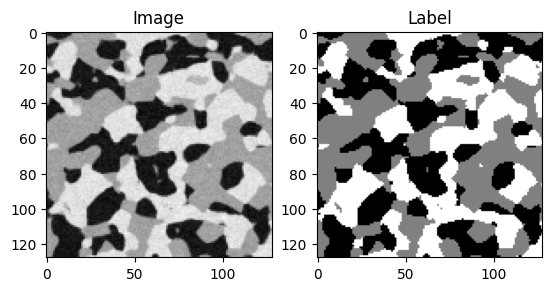

Cropped Image Shape: torch.Size([1, 16, 16])
Cropped Label Shape: torch.Size([1, 16, 16])


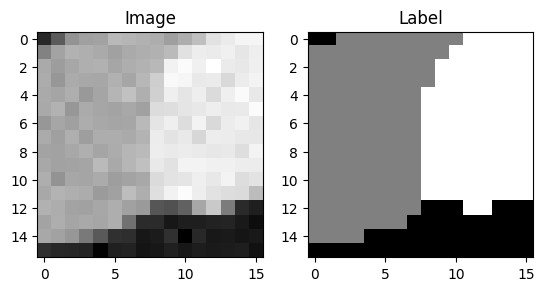

In [3]:

# Data loading and preprocessing
image_paths = sorted(glob.glob("drive/My Drive/Colab Notebooks/project /data/*.tiff"))
label_paths = sorted(glob.glob("drive/My Drive/Colab Notebooks/project /labels/*.tif"))

# Set the percentage splits
train_split = 0.80
validation_split = 0.10
test_split = 0.10

# Split the image paths into train, validation, and test sets
train_image_paths = image_paths[:int(len(image_paths) * train_split)]
validation_image_paths = image_paths[int(len(image_paths) * train_split):int(len(image_paths) * (train_split + validation_split))]
test_image_paths = image_paths[int(len(image_paths) * (train_split + validation_split)):int(len(image_paths) * (train_split + validation_split + test_split))]

print("Total Observations train:\t", len(train_image_paths))
print("Total Observations validation:\t", len(validation_image_paths))
print("Total Observations test:\t", len(test_image_paths))

train_label_paths = label_paths[:int(len(label_paths) * train_split)]
validation_label_paths = label_paths[int(len(label_paths) * train_split):int(len(label_paths) * (train_split + validation_split))]
test_label_paths = label_paths[int(len(label_paths) * (train_split + validation_split)):int(len(label_paths) * (train_split + validation_split + test_split))]

print("Total Observations labels train:\t", len(train_label_paths))
print("Total Observations labels validation:\t", len(validation_label_paths))
print("Total Observations labels test:\t", len(test_label_paths))

train_dataset = CustomDataset(train_image_paths, train_label_paths)
validation_dataset = CustomDataset(validation_image_paths, validation_label_paths)
test_dataset = CustomDataset(test_image_paths, test_label_paths)

import matplotlib.colors as mcolors

# Print the shapes of the first sample
sample_img, sample_lbl = train_dataset[0]
print("Image Shape:", sample_img.shape)
print("Label Shape:", sample_lbl.shape)
cmap = mcolors.ListedColormap(['black', 'gray', 'white'])

# Visualize the first sample
plt.subplot(1, 2, 1)
plt.imshow(sample_img[0], cmap='gray')
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(sample_lbl[0], cmap='gray')
plt.title('Label')

plt.show()

crop_size = (16, 16)
# Create cropped datasets
cropped_train_dataset = CropDataset(train_dataset, crop_size)
cropped_validation_dataset = CropDataset(validation_dataset, crop_size)
cropped_test_dataset = CropDataset(test_dataset, crop_size)

# Access the cropped images and labels
cropped_image, cropped_label = cropped_train_dataset[0]
print("Cropped Image Shape:", cropped_image.shape)
print("Cropped Label Shape:", cropped_label.shape)

# Visualize the first sample
plt.subplot(1, 2, 1)
plt.imshow(cropped_image[0], cmap='gray')
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(cropped_label[0], cmap='gray')
plt.title('Label')

plt.show()



Epoch 1/25
Train Loss: 1.0173788976669311, Validation Loss: 0.8768699020147324
Epoch 2/25
Train Loss: 1.0039289808273315, Validation Loss: 0.9935440123081207
Epoch 3/25
Train Loss: 0.81887531042099, Validation Loss: 0.7038316577672958
Epoch 4/25
Train Loss: 0.4839484119415283, Validation Loss: 0.4563271552324295
Epoch 5/25
Train Loss: 0.3703681743144989, Validation Loss: 0.3593224659562111
Epoch 6/25
Train Loss: 0.3090904623270035, Validation Loss: 0.45788053423166275
Epoch 7/25
Train Loss: 0.2553671270608902, Validation Loss: 0.26584404334425926
Epoch 8/25
Train Loss: 0.19051473200321198, Validation Loss: 0.2494058944284916
Epoch 9/25
Train Loss: 0.16032740235328674, Validation Loss: 0.2530140355229378
Epoch 10/25
Train Loss: 0.1525281485915184, Validation Loss: 0.2224697545170784
Epoch 11/25
Train Loss: 0.13807858616113663, Validation Loss: 0.20925216376781464
Epoch 12/25
Train Loss: 0.12233583897352218, Validation Loss: 0.2738722264766693
Epoch 13/25
Train Loss: 0.1305983167886734, 

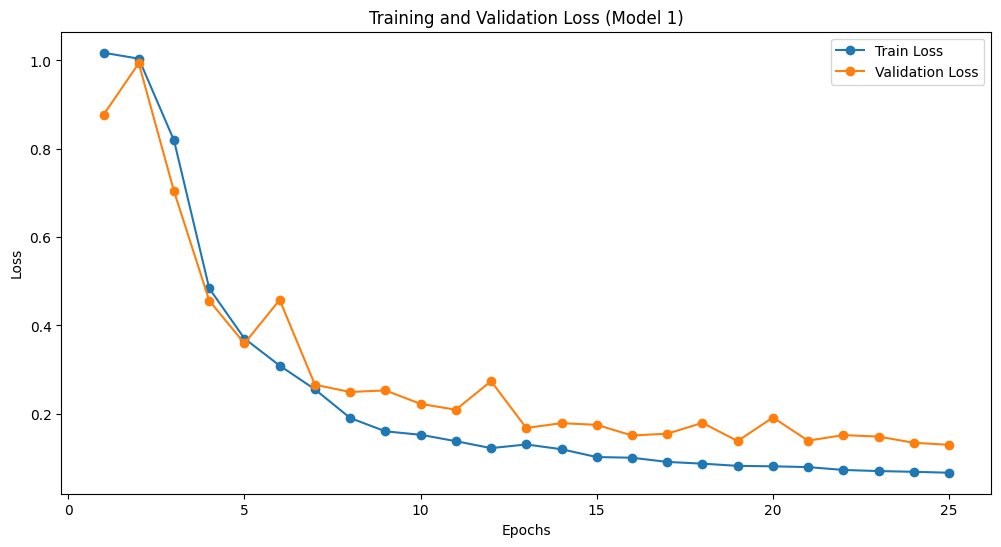

In [4]:
from torch import optim
# Define the model, loss function, and optimizer
in_channels = 1
out_channels = 3
model = UNet(in_channels, out_channels)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(cropped_train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(cropped_validation_dataset, batch_size=16, shuffle=False)  # No need to shuffle validation data

# Training parameters
epochs = 25

# Lists to store training and validation metrics
train_loss_history = []
val_loss_history = []

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Training
    model.train()
    total_train_loss = 0.0
    num_train_batches = 0
    for batch_images, batch_labels in train_loader:
        optimizer.zero_grad()
        output = model(batch_images)
        batch_labels = batch_labels.squeeze(1).long()  # Convert labels to Long type
        loss = criterion(output, batch_labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        num_train_batches += 1

    # Store average training loss for the epoch
    avg_train_loss = total_train_loss / num_train_batches
    train_loss_history.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0.0
    num_val_batches = 0
    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            output = model(batch_images)
            batch_labels = batch_labels.squeeze(1).long()  # Convert labels to Long type
            val_loss = criterion(output, batch_labels)
            total_val_loss += val_loss.item()
            num_val_batches += 1

    # Store average validation loss for the epoch
    avg_val_loss = total_val_loss / num_val_batches
    val_loss_history.append(avg_val_loss)

    # Print and store metrics
    print(f"Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

print("Training finished.")

# Plot training and validation loss
plt.figure(figsize=(12, 6))
epochs = np.arange(1, epochs + 1)
plt.plot(epochs, train_loss_history, label='Train Loss', marker='o')
plt.plot(epochs, val_loss_history, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss (Model 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Total number of test images: 50
Average Pixel-wise Accuracy: 96.0690%


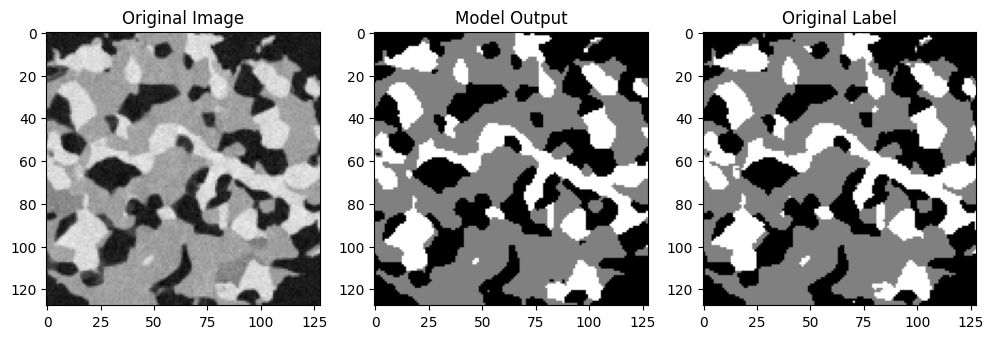

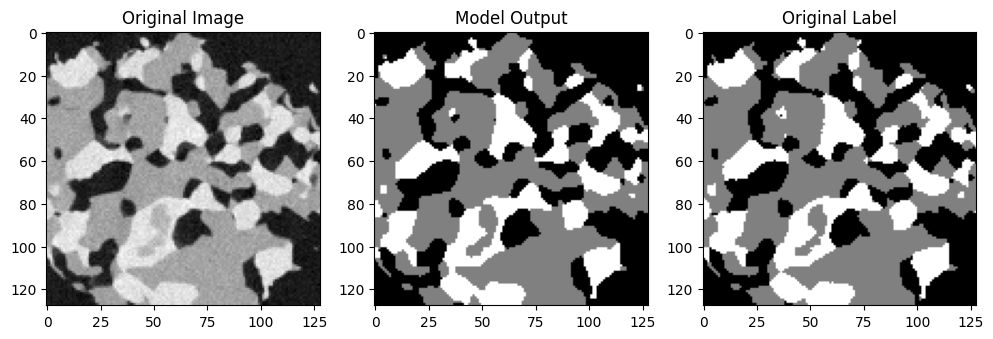

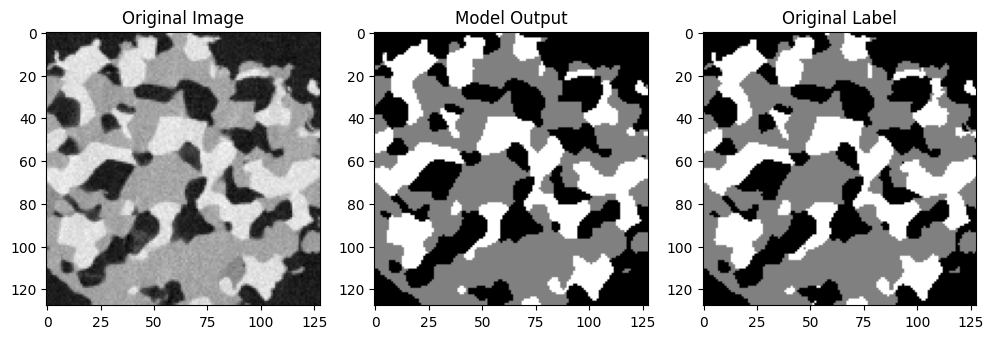

In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
#cropped_test_dataset
total_test_images = len(test_dataset)
print(f"Total number of test images: {total_test_images}")

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

# Load the saved model
loaded_model1 = UNet(in_channels, out_channels)
loaded_model1.load_state_dict(torch.load('trained_model.pth'))
loaded_model1.eval()

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

num_classes = 3

# Lists to store evaluation metrics
pixel_accuracy_history = []  # List to store pixel-wise accuracy values

with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        # Forward pass
        output = loaded_model1(batch_images)

        # Apply post-processing to get predicted class indices
        predicted_classes = post_process(output)

        # Calculate pixel-wise accuracy
        correct_pixels = (predicted_classes == batch_labels).sum().item()
        total_pixels = batch_labels.numel()
        pixel_accuracy = correct_pixels / total_pixels
        pixel_accuracy_history.append(pixel_accuracy)

# Calculate and print the average pixel-wise accuracy
average_pixel_accuracy1 = sum(pixel_accuracy_history) / len(pixel_accuracy_history)
print(f"Average Pixel-wise Accuracy: {average_pixel_accuracy1:.4%}")

# Visualize results for a few random samples
num_samples = 3
sample_indices = torch.randint(0, len(cropped_test_dataset), (num_samples,))

for idx in sample_indices:
    original_image, original_label = test_dataset[idx]
    model_output = loaded_model1(original_image.unsqueeze(0))

    # Apply post-processing to get predicted class indices
    predicted_classes = post_process(model_output)

    # Plot the images
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_classes.squeeze(), cmap='gray')
    plt.title('Model Output')

    plt.subplot(1, 3, 3)
    plt.imshow(original_label.squeeze(), cmap='gray')
    plt.title('Original Label')

    plt.show()





# **Model 2 (250 images)**

Total Observations labels train:	 200
Total Observations labels validation:	 25
Total Observations labels test:	 50
Total Observations train:	 200
Total Observations validation:	 25
Total Observations test:	 50
Image Shape: torch.Size([1, 128, 128])
Label Shape: torch.Size([1, 128, 128])


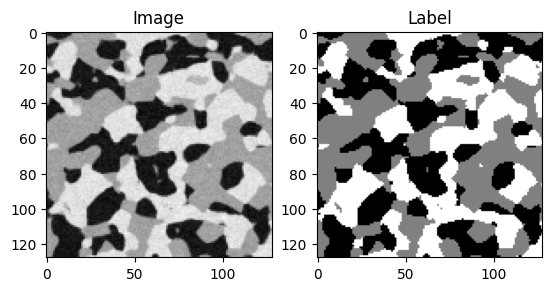

Cropped Image Shape: torch.Size([1, 16, 16])
Cropped Label Shape: torch.Size([1, 16, 16])


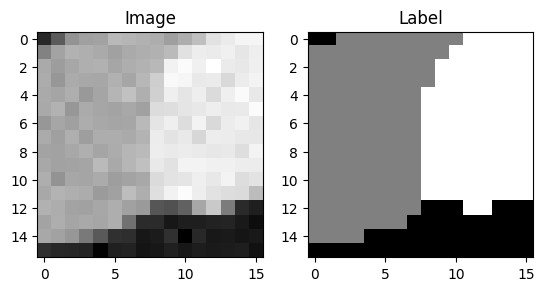

In [6]:

# Data loading and preprocessing
image_paths = sorted(glob.glob("drive/My Drive/Colab Notebooks/project /data/*.tiff"))
label_paths = sorted(glob.glob("drive/My Drive/Colab Notebooks/project /labels/*.tif"))

# Set the number of images to remove
num_images_to_remove = 250

# Remove the last num_images_to_remove images
removed_image_paths = image_paths[-num_images_to_remove:]
removed_label_paths = label_paths[-num_images_to_remove:]

# Set the number of images for the fixed test split
num_fixed_test_images = 50

# Use 50 images from the removed set for the test split
test_image_paths = removed_image_paths[:num_fixed_test_images]
test_label_paths = removed_label_paths[:num_fixed_test_images]

# Update the remaining image paths after removing test images
remaining_image_paths = image_paths[:-num_images_to_remove]
remaining_label_paths = label_paths[:-num_images_to_remove]

# Set the percentage splits for training and validation
train_split = 0.80
validation_split = 0.10

# Split the remaining image paths into train and validation sets
train_image_paths = remaining_image_paths[:int(len(remaining_image_paths) * train_split)]
validation_image_paths = remaining_image_paths[int(len(remaining_image_paths) * train_split):int(len(remaining_image_paths) * (train_split + validation_split))]
train_label_paths = remaining_label_paths[:int(len(remaining_label_paths) * train_split)]
validation_label_paths = remaining_label_paths[int(len(remaining_label_paths) * train_split):int(len(remaining_label_paths) * (train_split + validation_split))]

print("Total Observations labels train:\t", len(train_label_paths))
print("Total Observations labels validation:\t", len(validation_label_paths))
print("Total Observations labels test:\t", len(test_label_paths))
print("Total Observations train:\t", len(train_image_paths))
print("Total Observations validation:\t", len(validation_image_paths))
print("Total Observations test:\t", len(test_image_paths))


train_dataset = CustomDataset(train_image_paths, train_label_paths)
validation_dataset = CustomDataset(validation_image_paths, validation_label_paths)
test_dataset = CustomDataset(test_image_paths, test_label_paths)

import matplotlib.colors as mcolors

# Print the shapes of the first sample
sample_img, sample_lbl = train_dataset[0]
print("Image Shape:", sample_img.shape)
print("Label Shape:", sample_lbl.shape)
cmap = mcolors.ListedColormap(['black', 'gray', 'white'])

# Visualize the first sample
plt.subplot(1, 2, 1)
plt.imshow(sample_img[0], cmap='gray')
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(sample_lbl[0], cmap='gray')
plt.title('Label')

plt.show()

crop_size = (16, 16)
# Create cropped datasets
cropped_train_dataset = CropDataset(train_dataset, crop_size)
cropped_validation_dataset = CropDataset(validation_dataset, crop_size)
cropped_test_dataset = CropDataset(test_dataset, crop_size)

# Access the cropped images and labels
cropped_image, cropped_label = cropped_train_dataset[0]
print("Cropped Image Shape:", cropped_image.shape)
print("Cropped Label Shape:", cropped_label.shape)

# Visualize the first sample
plt.subplot(1, 2, 1)
plt.imshow(cropped_image[0], cmap='gray')
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(cropped_label[0], cmap='gray')
plt.title('Label')

plt.show()



Epoch 1/25
Train Loss: 1.0738890446149385, Validation Loss: 0.9833458662033081
Epoch 2/25
Train Loss: 1.049821294271029, Validation Loss: 1.0873684883117676
Epoch 3/25
Train Loss: 0.9775981857226446, Validation Loss: 0.9990925192832947
Epoch 4/25
Train Loss: 0.8538419099954458, Validation Loss: 0.7707394957542419
Epoch 5/25
Train Loss: 0.6446723341941833, Validation Loss: 0.5849153101444244
Epoch 6/25
Train Loss: 0.4984010389217964, Validation Loss: 0.5212755799293518
Epoch 7/25
Train Loss: 0.41096919545760524, Validation Loss: 0.5056250095367432
Epoch 8/25
Train Loss: 0.35646446163837725, Validation Loss: 0.43689000606536865
Epoch 9/25
Train Loss: 0.354664894250723, Validation Loss: 0.5123756527900696
Epoch 10/25
Train Loss: 0.30465520918369293, Validation Loss: 0.39805519580841064
Epoch 11/25
Train Loss: 0.26642344892024994, Validation Loss: 0.3185807019472122
Epoch 12/25
Train Loss: 0.2340091042793714, Validation Loss: 0.2905682921409607
Epoch 13/25
Train Loss: 0.2060414208815648, V

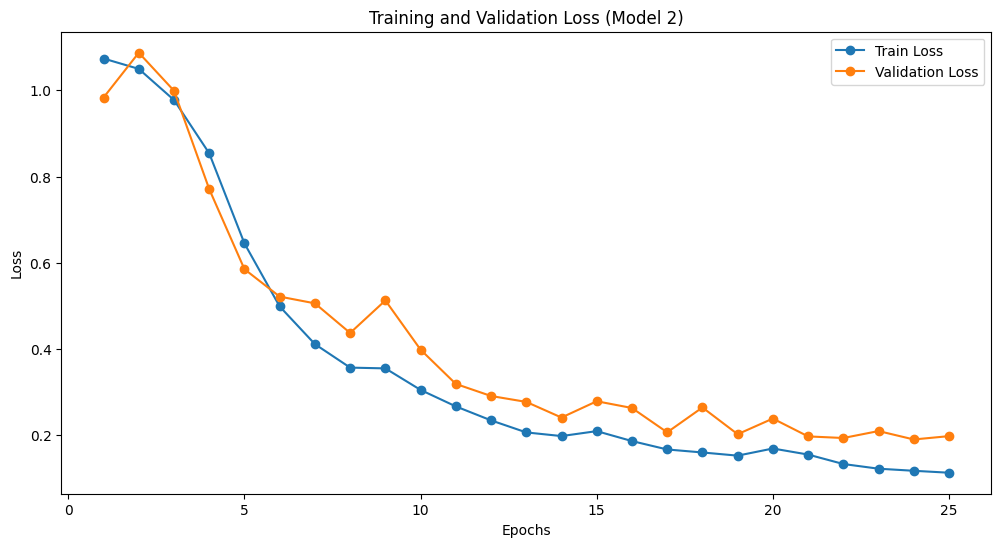

In [7]:
from torch import optim
# Define your model, loss function, and optimizer
in_channels = 1
out_channels = 3
model = UNet(in_channels, out_channels)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(cropped_train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(cropped_validation_dataset, batch_size=16, shuffle=False)

# Training parameters
epochs = 25

# Lists to store training and validation metrics
train_loss_history = []
val_loss_history = []

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Training
    model.train()
    total_train_loss = 0.0
    num_train_batches = 0
    for batch_images, batch_labels in train_loader:
        optimizer.zero_grad()
        output = model(batch_images)
        batch_labels = batch_labels.squeeze(1).long()  # Convert labels to Long type
        loss = criterion(output, batch_labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        num_train_batches += 1

    # Store average training loss for the epoch
    avg_train_loss = total_train_loss / num_train_batches
    train_loss_history.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0.0
    num_val_batches = 0
    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            output = model(batch_images)
            batch_labels = batch_labels.squeeze(1).long()  # Convert labels to Long type
            val_loss = criterion(output, batch_labels)
            total_val_loss += val_loss.item()
            num_val_batches += 1

    # Store average validation loss for the epoch
    avg_val_loss = total_val_loss / num_val_batches
    val_loss_history.append(avg_val_loss)

    # Print and store metrics
    print(f"Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

print("Training finished.")

# Plot training and validation loss
plt.figure(figsize=(12, 6))
epochs = np.arange(1, epochs + 1)
plt.plot(epochs, train_loss_history, label='Train Loss', marker='o')
plt.plot(epochs, val_loss_history, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss (Model 2)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Total number of test images: 50
Average Pixel-wise Accuracy: 94.1947%


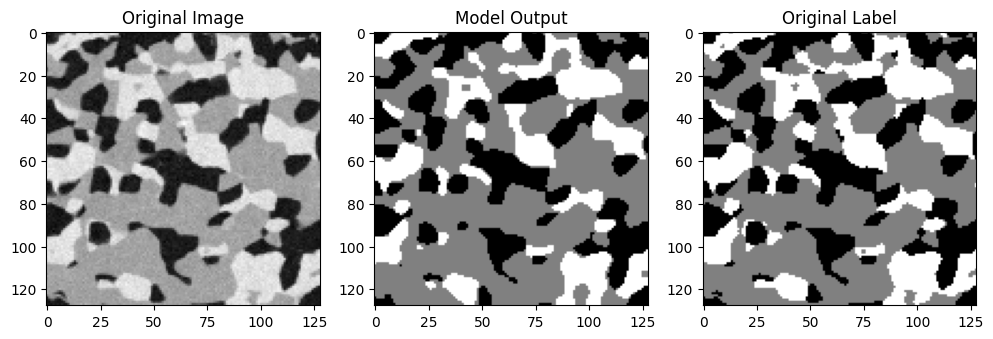

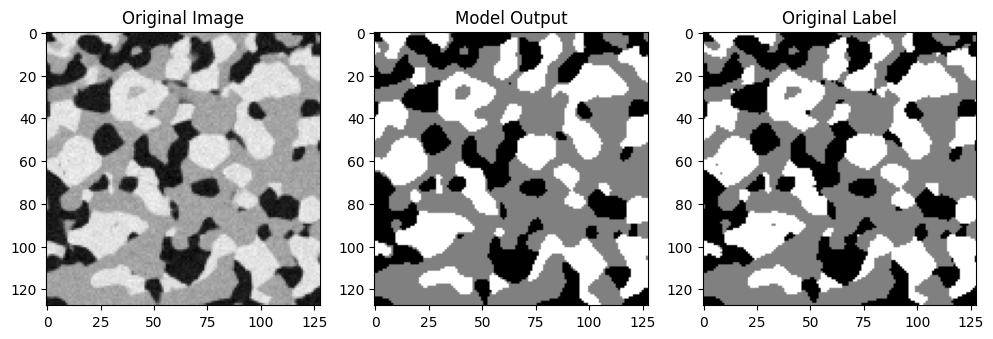

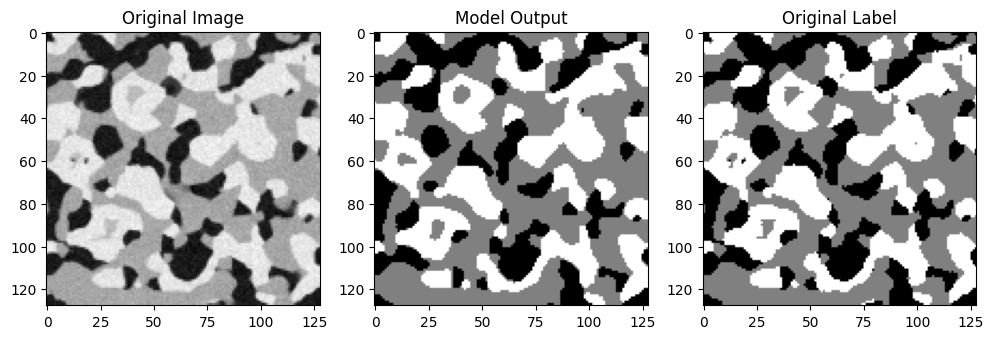

In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
#cropped_test_dataset
total_test_images = len(test_dataset)
print(f"Total number of test images: {total_test_images}")

# Save the trained model
torch.save(model.state_dict(), 'trained_model2.pth')

# Load the saved model
loaded_model2 = UNet(in_channels, out_channels)
loaded_model2.load_state_dict(torch.load('trained_model2.pth'))
loaded_model2.eval()


test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

num_classes = 3

# Lists to store evaluation metrics
pixel_accuracy_history = []  # List to store pixel-wise accuracy values

with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        # Forward pass
        output = loaded_model2(batch_images)

        # Apply post-processing to get predicted class indices
        predicted_classes = post_process(output)

        # Calculate pixel-wise accuracy
        correct_pixels = (predicted_classes == batch_labels).sum().item()
        total_pixels = batch_labels.numel()
        pixel_accuracy = correct_pixels / total_pixels
        pixel_accuracy_history.append(pixel_accuracy)

# Calculate and print the average pixel-wise accuracy
average_pixel_accuracy2 = sum(pixel_accuracy_history) / len(pixel_accuracy_history)
print(f"Average Pixel-wise Accuracy: {average_pixel_accuracy2:.4%}")

# Visualize results for a few random samples
num_samples = 3
sample_indices = torch.randint(0, len(cropped_test_dataset), (num_samples,))

for idx in sample_indices:
    original_image, original_label = test_dataset[idx]
    model_output = loaded_model2(original_image.unsqueeze(0))

    # Apply post-processing to get predicted class indices
    predicted_classes = post_process(model_output)

    # Plot the images
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_classes.squeeze(), cmap='gray')
    plt.title('Model Output')

    plt.subplot(1, 3, 3)
    plt.imshow(original_label.squeeze(), cmap='gray')
    plt.title('Original Label')

    plt.show()





# **Model 3 (100 images)**

Total Observations labels train:	 80
Total Observations labels validation:	 10
Total Observations labels test:	 50
Total Observations train:	 80
Total Observations validation:	 10
Total Observations test:	 50
Image Shape: torch.Size([1, 128, 128])
Label Shape: torch.Size([1, 128, 128])


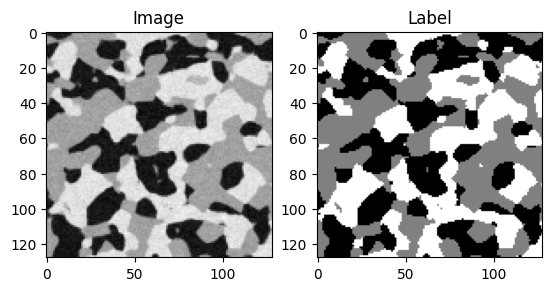

Cropped Image Shape: torch.Size([1, 16, 16])
Cropped Label Shape: torch.Size([1, 16, 16])


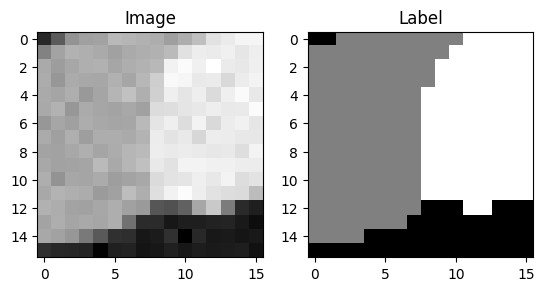

In [24]:

# Data loading and preprocessing
image_paths = sorted(glob.glob("drive/My Drive/Colab Notebooks/project /data/*.tiff"))
label_paths = sorted(glob.glob("drive/My Drive/Colab Notebooks/project /labels/*.tif"))

# Set the number of images to remove
num_images_to_remove = 400

# Remove the last num_images_to_remove images
removed_image_paths = image_paths[-num_images_to_remove:]
removed_label_paths = label_paths[-num_images_to_remove:]

# Set the number of images for the fixed test split
num_fixed_test_images = 50

# Use 50 images from the removed set for the test split
test_image_paths = removed_image_paths[:num_fixed_test_images]
test_label_paths = removed_label_paths[:num_fixed_test_images]

# Update the remaining image paths after removing test images
remaining_image_paths = image_paths[:-num_images_to_remove]
remaining_label_paths = label_paths[:-num_images_to_remove]

# Set the percentage splits for training and validation
train_split = 0.80
validation_split = 0.10

# Split the remaining image paths into train and validation sets
train_image_paths = remaining_image_paths[:int(len(remaining_image_paths) * train_split)]
validation_image_paths = remaining_image_paths[int(len(remaining_image_paths) * train_split):int(len(remaining_image_paths) * (train_split + validation_split))]
train_label_paths = remaining_label_paths[:int(len(remaining_label_paths) * train_split)]
validation_label_paths = remaining_label_paths[int(len(remaining_label_paths) * train_split):int(len(remaining_label_paths) * (train_split + validation_split))]

print("Total Observations labels train:\t", len(train_label_paths))
print("Total Observations labels validation:\t", len(validation_label_paths))
print("Total Observations labels test:\t", len(test_label_paths))
print("Total Observations train:\t", len(train_image_paths))
print("Total Observations validation:\t", len(validation_image_paths))
print("Total Observations test:\t", len(test_image_paths))


train_dataset = CustomDataset(train_image_paths, train_label_paths)
validation_dataset = CustomDataset(validation_image_paths, validation_label_paths)
test_dataset = CustomDataset(test_image_paths, test_label_paths)

import matplotlib.colors as mcolors

# Print the shapes of the first sample
sample_img, sample_lbl = train_dataset[0]
print("Image Shape:", sample_img.shape)
print("Label Shape:", sample_lbl.shape)
cmap = mcolors.ListedColormap(['black', 'gray', 'white'])

# Visualize the first sample
plt.subplot(1, 2, 1)
plt.imshow(sample_img[0], cmap='gray')
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(sample_lbl[0], cmap='gray')
plt.title('Label')

plt.show()

crop_size = (16, 16)
# Create cropped datasets
cropped_train_dataset = CropDataset(train_dataset, crop_size)
cropped_validation_dataset = CropDataset(validation_dataset, crop_size)
cropped_test_dataset = CropDataset(test_dataset, crop_size)

# Access the cropped images and labels
cropped_image, cropped_label = cropped_train_dataset[0]
print("Cropped Image Shape:", cropped_image.shape)
print("Cropped Label Shape:", cropped_label.shape)

# Visualize the first sample
plt.subplot(1, 2, 1)
plt.imshow(cropped_image[0], cmap='gray')
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(cropped_label[0], cmap='gray')
plt.title('Label')

plt.show()



Epoch 1/25
Train Loss: 1.0250216960906982, Validation Loss: 1.1309158404668171
Epoch 2/25
Train Loss: 0.9475099861621856, Validation Loss: 1.0530236164728801
Epoch 3/25
Train Loss: 0.8284114122390747, Validation Loss: 0.9300248026847839
Epoch 4/25
Train Loss: 0.6219650432467461, Validation Loss: 0.6381773352622986
Epoch 5/25
Train Loss: 0.4049250364303589, Validation Loss: 0.5029276907444
Epoch 6/25
Train Loss: 0.29472003504633904, Validation Loss: 0.4506281117598216
Epoch 7/25
Train Loss: 0.23553046435117722, Validation Loss: 0.37711528937021893
Epoch 8/25
Train Loss: 0.20520275682210923, Validation Loss: 0.39823708931605023
Epoch 9/25
Train Loss: 0.1892586663365364, Validation Loss: 0.314470241467158
Epoch 10/25
Train Loss: 0.17620452344417573, Validation Loss: 0.2888290385405223
Epoch 11/25
Train Loss: 0.15279735065996647, Validation Loss: 0.35010183850924176
Epoch 12/25
Train Loss: 0.13183375187218188, Validation Loss: 0.30127838750680286
Epoch 13/25
Train Loss: 0.12656686305999756

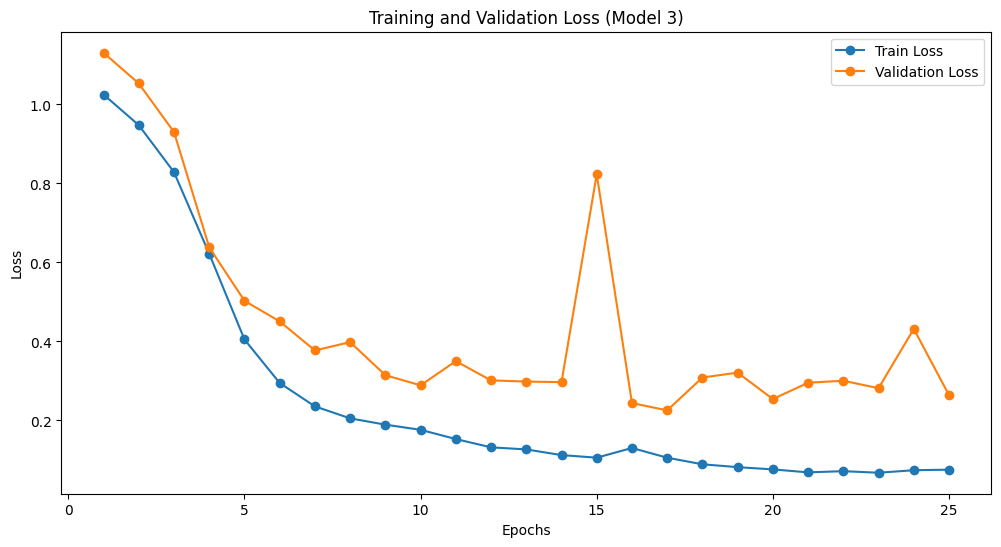

In [27]:
from torch import optim
# Define your model, loss function, and optimizer
in_channels = 1
out_channels = 3
model = UNet(in_channels, out_channels)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(cropped_train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(cropped_validation_dataset, batch_size=4, shuffle=False)

# Training parameters
epochs = 25

# Lists to store training and validation metrics
train_loss_history = []
val_loss_history = []

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Training
    model.train()
    total_train_loss = 0.0
    num_train_batches = 0
    for batch_images, batch_labels in train_loader:
        optimizer.zero_grad()
        output = model(batch_images)
        batch_labels = batch_labels.squeeze(1).long()  # Convert labels to Long type
        loss = criterion(output, batch_labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        num_train_batches += 1

    # Store average training loss for the epoch
    avg_train_loss = total_train_loss / num_train_batches
    train_loss_history.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0.0
    num_val_batches = 0
    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            output = model(batch_images)
            batch_labels = batch_labels.squeeze(1).long()  # Convert labels to Long type
            val_loss = criterion(output, batch_labels)
            total_val_loss += val_loss.item()
            num_val_batches += 1

    # Store average validation loss for the epoch
    avg_val_loss = total_val_loss / num_val_batches
    val_loss_history.append(avg_val_loss)

    # Print and store metrics
    print(f"Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

print("Training finished.")

# Plot training and validation loss
plt.figure(figsize=(12, 6))
epochs = np.arange(1, epochs + 1)
plt.plot(epochs, train_loss_history, label='Train Loss', marker='o')
plt.plot(epochs, val_loss_history, label='Validation Loss', marker='o')

plt.title('Training and Validation Loss (Model 3)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Total number of test images: 50
Average Pixel-wise Accuracy: 75.7434%


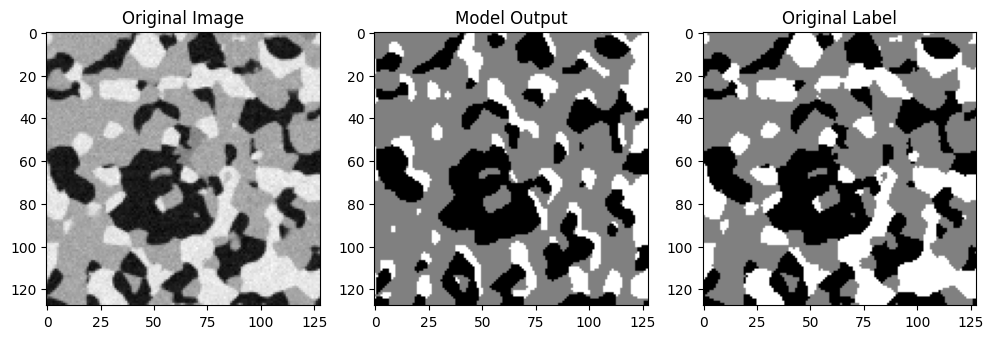

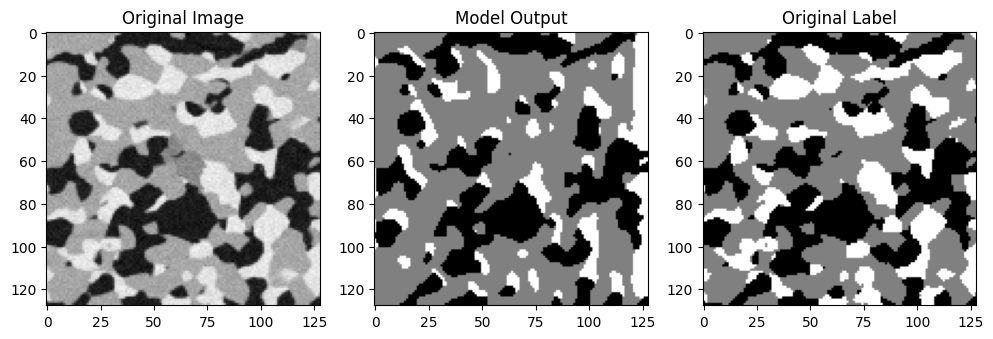

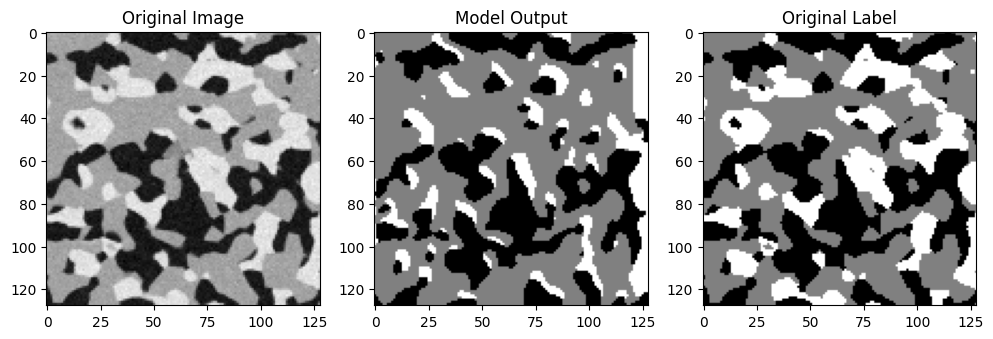

In [28]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
#cropped_test_dataset
total_test_images = len(test_dataset)
print(f"Total number of test images: {total_test_images}")

# Save the trained model
torch.save(model.state_dict(), 'trained_model3.pth')

# Load the saved model
loaded_model3 = UNet(in_channels, out_channels)
loaded_model3.load_state_dict(torch.load('trained_model3.pth'))
loaded_model3.eval()


test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

num_classes = 3

# Lists to store evaluation metrics
pixel_accuracy_history = []  # List to store pixel-wise accuracy values

with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        # Forward pass
        output = loaded_model3(batch_images)

        # Apply post-processing to get predicted class indices
        predicted_classes = post_process(output)

        # Calculate pixel-wise accuracy
        correct_pixels = (predicted_classes == batch_labels).sum().item()
        total_pixels = batch_labels.numel()
        pixel_accuracy = correct_pixels / total_pixels
        pixel_accuracy_history.append(pixel_accuracy)

# Calculate and print the average pixel-wise accuracy
average_pixel_accuracy3 = sum(pixel_accuracy_history) / len(pixel_accuracy_history)
print(f"Average Pixel-wise Accuracy: {average_pixel_accuracy3:.4%}")

# Visualize results for a few random samples
num_samples = 3
sample_indices = torch.randint(0, len(cropped_test_dataset), (num_samples,))

for idx in sample_indices:
    original_image, original_label = test_dataset[idx]
    model_output = loaded_model3(original_image.unsqueeze(0))

    # Apply post-processing to get predicted class indices
    predicted_classes = post_process(model_output)

    # Plot the images
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_classes.squeeze(), cmap='gray')
    plt.title('Model Output')

    plt.subplot(1, 3, 3)
    plt.imshow(original_label.squeeze(), cmap='gray')
    plt.title('Original Label')

    plt.show()





# **Model 4 (50 images)**

Total Observations labels train:	 40
Total Observations labels validation:	 5
Total Observations labels test:	 50
Total Observations train:	 40
Total Observations validation:	 5
Total Observations test:	 50
Image Shape: torch.Size([1, 128, 128])
Label Shape: torch.Size([1, 128, 128])


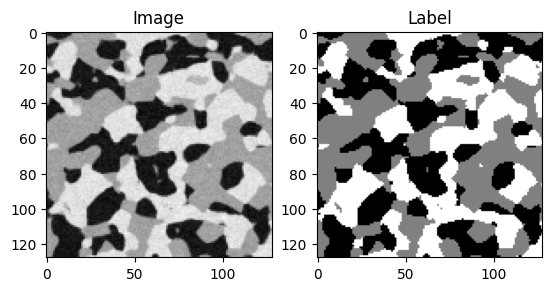

Cropped Image Shape: torch.Size([1, 16, 16])
Cropped Label Shape: torch.Size([1, 16, 16])


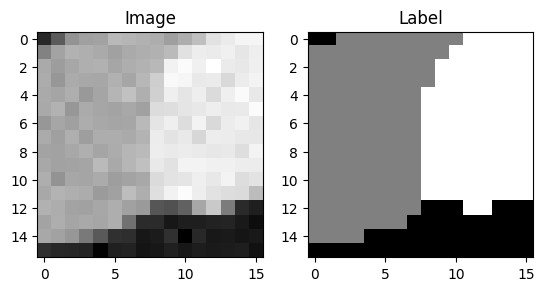

In [29]:

# Data loading and preprocessing
image_paths = sorted(glob.glob("drive/My Drive/Colab Notebooks/project /data/*.tiff"))
label_paths = sorted(glob.glob("drive/My Drive/Colab Notebooks/project /labels/*.tif"))

# Set the number of images to remove
num_images_to_remove = 450

# Remove the last num_images_to_remove images
removed_image_paths = image_paths[-num_images_to_remove:]
removed_label_paths = label_paths[-num_images_to_remove:]

# Set the number of images for the fixed test split
num_fixed_test_images = 50

# Use 50 images from the removed set for the test split
test_image_paths = removed_image_paths[:num_fixed_test_images]
test_label_paths = removed_label_paths[:num_fixed_test_images]

# Update the remaining image paths after removing test images
remaining_image_paths = image_paths[:-num_images_to_remove]
remaining_label_paths = label_paths[:-num_images_to_remove]

# Set the percentage splits for training and validation
train_split = 0.80
validation_split = 0.10

# Split the remaining image paths into train and validation sets
train_image_paths = remaining_image_paths[:int(len(remaining_image_paths) * train_split)]
validation_image_paths = remaining_image_paths[int(len(remaining_image_paths) * train_split):int(len(remaining_image_paths) * (train_split + validation_split))]
train_label_paths = remaining_label_paths[:int(len(remaining_label_paths) * train_split)]
validation_label_paths = remaining_label_paths[int(len(remaining_label_paths) * train_split):int(len(remaining_label_paths) * (train_split + validation_split))]

print("Total Observations labels train:\t", len(train_label_paths))
print("Total Observations labels validation:\t", len(validation_label_paths))
print("Total Observations labels test:\t", len(test_label_paths))
print("Total Observations train:\t", len(train_image_paths))
print("Total Observations validation:\t", len(validation_image_paths))
print("Total Observations test:\t", len(test_image_paths))


train_dataset = CustomDataset(train_image_paths, train_label_paths)
validation_dataset = CustomDataset(validation_image_paths, validation_label_paths)
test_dataset = CustomDataset(test_image_paths, test_label_paths)

import matplotlib.colors as mcolors

# Print the shapes of the first sample
sample_img, sample_lbl = train_dataset[0]
print("Image Shape:", sample_img.shape)
print("Label Shape:", sample_lbl.shape)
cmap = mcolors.ListedColormap(['black', 'gray', 'white'])

# Visualize the first sample
plt.subplot(1, 2, 1)
plt.imshow(sample_img[0], cmap='gray')
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(sample_lbl[0], cmap='gray')
plt.title('Label')

plt.show()

crop_size = (16, 16)
# Create cropped datasets
cropped_train_dataset = CropDataset(train_dataset, crop_size)
cropped_validation_dataset = CropDataset(validation_dataset, crop_size)
cropped_test_dataset = CropDataset(test_dataset, crop_size)

# Access the cropped images and labels
cropped_image, cropped_label = cropped_train_dataset[0]
print("Cropped Image Shape:", cropped_image.shape)
print("Cropped Label Shape:", cropped_label.shape)

# Visualize the first sample
plt.subplot(1, 2, 1)
plt.imshow(cropped_image[0], cmap='gray')
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(cropped_label[0], cmap='gray')
plt.title('Label')

plt.show()



Epoch 1/25
Train Loss: 1.061503255367279, Validation Loss: 1.260713517665863
Epoch 2/25
Train Loss: 0.9913597285747529, Validation Loss: 1.049346148967743
Epoch 3/25
Train Loss: 0.743861711025238, Validation Loss: 1.2950162887573242
Epoch 4/25
Train Loss: 0.7229171872138977, Validation Loss: 0.9580127596855164
Epoch 5/25
Train Loss: 0.6221428513526917, Validation Loss: 0.9121341705322266
Epoch 6/25
Train Loss: 0.5556669026613236, Validation Loss: 0.9247001707553864
Epoch 7/25
Train Loss: 0.5002403229475021, Validation Loss: 0.9877385199069977
Epoch 8/25
Train Loss: 0.48756648004055025, Validation Loss: 1.0101465582847595
Epoch 9/25
Train Loss: 0.4657934337854385, Validation Loss: 0.7907534539699554
Epoch 10/25
Train Loss: 0.3774150609970093, Validation Loss: 0.7688554227352142
Epoch 11/25
Train Loss: 0.29779637008905413, Validation Loss: 0.47361621260643005
Epoch 12/25
Train Loss: 0.2543686330318451, Validation Loss: 0.37775467336177826
Epoch 13/25
Train Loss: 0.20362381637096405, Vali

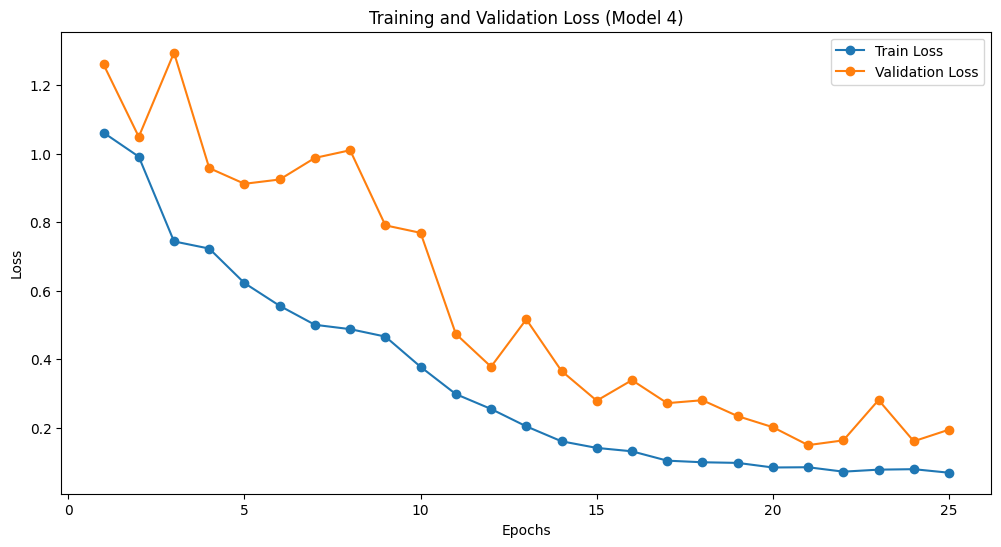

In [18]:
from torch import optim
# Define your model, loss function, and optimizer
in_channels = 1
out_channels = 3
model = UNet(in_channels, out_channels)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_loader = DataLoader(cropped_train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(cropped_validation_dataset, batch_size=4, shuffle=False)

# Training parameters
epochs = 25

# Lists to store training and validation metrics
train_loss_history = []
val_loss_history = []

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Training
    model.train()
    total_train_loss = 0.0
    num_train_batches = 0
    for batch_images, batch_labels in train_loader:
        optimizer.zero_grad()
        output = model(batch_images)
        batch_labels = batch_labels.squeeze(1).long()  # Convert labels to Long type
        loss = criterion(output, batch_labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        num_train_batches += 1

    # Store average training loss for the epoch
    avg_train_loss = total_train_loss / num_train_batches
    train_loss_history.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0.0
    num_val_batches = 0
    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            output = model(batch_images)
            batch_labels = batch_labels.squeeze(1).long()  # Convert labels to Long type
            val_loss = criterion(output, batch_labels)
            total_val_loss += val_loss.item()
            num_val_batches += 1

    # Store average validation loss for the epoch
    avg_val_loss = total_val_loss / num_val_batches
    val_loss_history.append(avg_val_loss)

    # Print and store metrics
    print(f"Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

print("Training finished.")

# Plot training and validation loss
plt.figure(figsize=(12, 6))
epochs = np.arange(1, epochs + 1)
plt.plot(epochs, train_loss_history, label='Train Loss', marker='o')
plt.plot(epochs, val_loss_history, label='Validation Loss', marker='o')

plt.title('Training and Validation Loss (Model 4)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Total number of test images: 50
Average Pixel-wise Accuracy: 68.2960%


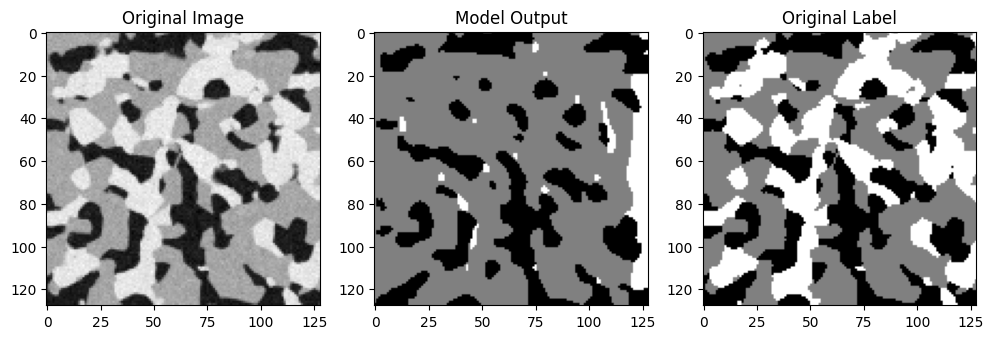

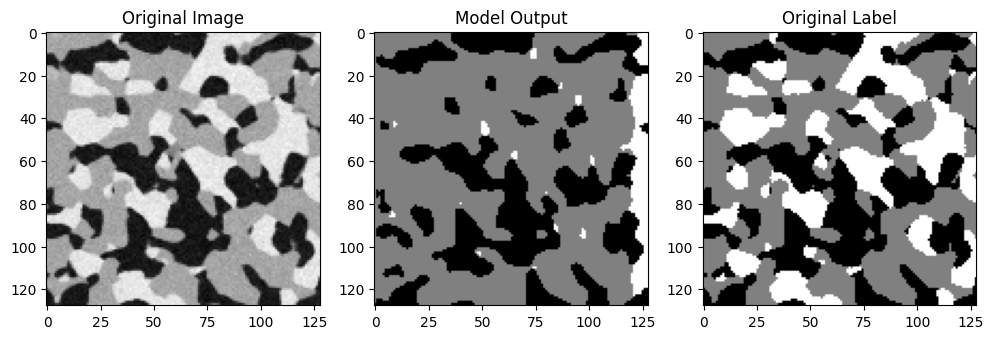

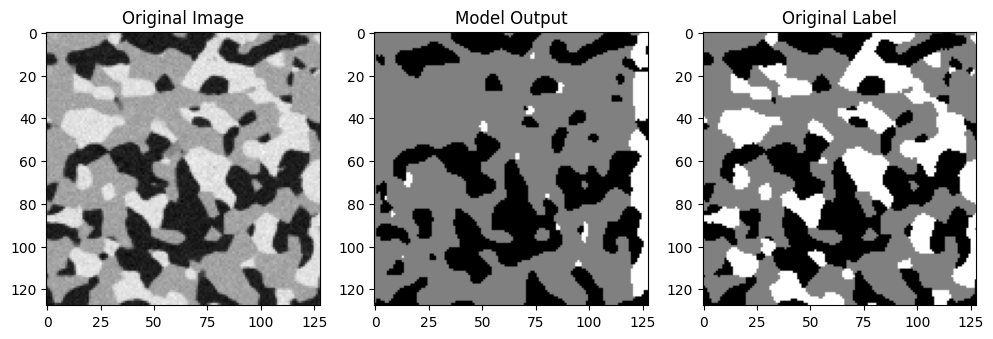

In [19]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
#cropped_test_dataset
total_test_images = len(test_dataset)
print(f"Total number of test images: {total_test_images}")

# Save the trained model
torch.save(model.state_dict(), 'trained_model4.pth')

# Load the saved model
loaded_model4 = UNet(in_channels, out_channels)
loaded_model4.load_state_dict(torch.load('trained_model4.pth'))
loaded_model4.eval()


test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

num_classes = 3

# Lists to store evaluation metrics

pixel_accuracy_history = []

with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        # Forward pass
        output = loaded_model4(batch_images)

        # Apply post-processing to get predicted class indices
        predicted_classes = post_process(output)

        # Calculate pixel-wise accuracy for each image in the batch
        for i in range(batch_images.size(0)):
            correct_pixels = (predicted_classes[i] == batch_labels[i]).sum().item()
            total_pixels = batch_labels[i].numel()
            pixel_accuracy = correct_pixels / total_pixels
            pixel_accuracy_history.append(pixel_accuracy)

# Calculate and print the average pixel-wise accuracy
average_pixel_accuracy4 = sum(pixel_accuracy_history) / len(pixel_accuracy_history)
print(f"Average Pixel-wise Accuracy: {average_pixel_accuracy4:.4%}")


# Visualize results for a few random samples
num_samples = 3
sample_indices = torch.randint(0, len(cropped_test_dataset), (num_samples,))

for idx in sample_indices:
    original_image, original_label = test_dataset[idx]
    model_output = loaded_model4(original_image.unsqueeze(0))

    # Apply post-processing to get predicted class indices
    predicted_classes = post_process(model_output)

    # Plot the images
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_classes.squeeze(), cmap='gray')
    plt.title('Model Output')

    plt.subplot(1, 3, 3)
    plt.imshow(original_label.squeeze(), cmap='gray')
    plt.title('Original Label')

    plt.show()





# **plot accuracy plot**

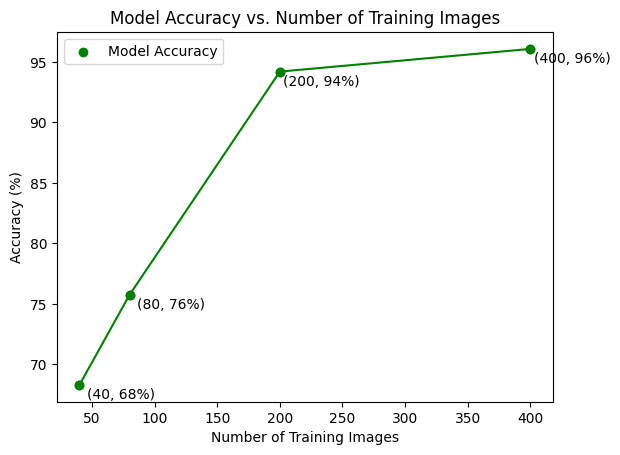

In [30]:
import matplotlib.pyplot as plt

# Example data
model_data = [
    {'accuracy': average_pixel_accuracy1, 'num_images': 400},
    {'accuracy': average_pixel_accuracy2, 'num_images': 200},
    {'accuracy': average_pixel_accuracy3, 'num_images': 80},
    {'accuracy': average_pixel_accuracy4, 'num_images': 40},

]

# Extract data for plotting
accuracies = [data['accuracy'] for data in model_data]
num_images = [data['num_images'] for data in model_data]

# Create scatter plot
plt.scatter(num_images, [acc * 100 for acc in accuracies], label='Model Accuracy', color='green')
plt.plot(num_images, [acc * 100 for acc in accuracies], linestyle='-', marker='o', color='green')
plt.title('Model Accuracy vs. Number of Training Images')
plt.xlabel('Number of Training Images')
plt.ylabel('Accuracy (%)')

# Annotate data points with x and y values
for i, txt in enumerate(model_data):
    plt.annotate(f"({num_images[i]}, {accuracies[i]*100:.0f}%)", (num_images[i], accuracies[i] * 100), textcoords="offset points", xytext=(30,-10), ha='center')

plt.legend()
plt.show()








